## Load librarys

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import csv
import random
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from numpy.random import seed
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from collections import Counter

parentDir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(parentDir, "general_utils"))
import file_management
from data_preprocessing import data_preprocessing

seed(0)

2023-03-22 18:09:01.707363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [26]:
# train_test_path = os.path.join('Classification datasets', 'Train and test sets')
# X_train, X_test, y_train, y_test, std_scale, cluster_id_train, cluster_id_test = data_preprocessing(train_test_path, use_spectral_bands=True, use_indices=True)

In [3]:
df = file_management.load_pickle('Processed Data/QPCR_labelled_df2.lzma')
# replace nan values in the PCR column with 0
# df['PCR'] = df['PCR'].fillna(0)
# remove all rows with cluster_id == 65535
df = df.loc[df['cluster_id'] != 65535]
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
17,101.791316,105.028978,92.869693,80.781102,82.648763,87.892319,105.754415,68.802438,0.122639,-0.091424,...,-0.027296,-0.031158,0.203227,0.138740,0.003442,0.811943,0,39.618415,2.581133,NaN
18,106.277035,106.998271,92.443685,82.544882,81.172892,90.712394,108.550410,71.596446,0.144302,-0.062686,...,-0.005897,-0.006732,0.196644,0.174233,0.007201,0.763786,0,39.618415,2.581139,NaN
19,115.938584,114.219013,97.768783,93.480315,86.830397,99.329288,114.800282,77.533712,0.138718,-0.056562,...,0.013032,0.014878,0.155755,0.174202,0.002538,0.748934,0,39.618415,2.581145,NaN
29,60.384679,58.094153,51.333936,38.450394,42.554274,43.711153,63.485543,38.184771,0.197391,-0.054119,...,0.033620,0.038342,0.452388,0.236717,0.044344,0.704720,1,39.618415,2.581203,NaN
30,75.912168,70.238129,60.067095,43.741732,45.014058,53.268072,80.919397,49.011551,0.285114,0.042515,...,0.067594,0.077119,0.519098,0.347150,0.070663,0.592976,1,39.618415,2.581209,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781331,104.206703,77.787087,63.475157,53.618898,38.372640,67.525115,88.320561,57.626408,0.394243,0.200562,...,0.253001,0.288749,0.307966,0.391419,0.063414,0.368236,2530,39.614754,2.586622,NaN
781332,97.650652,74.504931,61.771126,50.267717,36.158834,68.151798,95.228315,58.906995,0.449583,0.239289,...,0.234261,0.267340,0.397297,0.541632,0.122094,0.370288,2530,39.614754,2.586628,NaN
781333,92.474823,72.207422,60.919111,48.327559,35.174920,68.621811,99.833483,59.954747,0.478923,0.260485,...,0.214396,0.244654,0.454836,0.638788,0.160578,0.380373,2530,39.614754,2.586634,NaN
781334,89.714380,70.894560,60.493103,46.740157,33.945028,68.465140,101.807127,60.071164,0.499897,0.277890,...,0.204108,0.232906,0.486992,0.682954,0.178994,0.378368,2530,39.614754,2.586640,NaN


In [5]:
# find unique values in the PCR column
df.dropna(subset=['PCR'], inplace=True)
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
61299,122.494635,108.311133,93.082697,97.007874,78.713108,94.315822,105.754415,69.384523,0.146591,-0.062989,...,0.107193,0.122374,0.121280,0.136134,-0.011944,0.642584,261,39.618129,2.583230,1.0
61300,122.839690,106.341840,89.674635,95.596850,75.515388,94.159151,105.918885,71.363612,0.167573,-0.028267,...,0.125564,0.143346,0.124892,0.181147,-0.001993,0.614747,261,39.618129,2.583236,1.0
61301,125.255077,107.982918,89.035623,97.007874,76.253323,96.039201,107.892529,74.623288,0.171816,-0.010804,...,0.129179,0.147475,0.123422,0.211791,-0.000419,0.608784,261,39.618129,2.583242,1.0
61302,136.641902,119.142247,99.472814,108.472441,87.322354,106.692816,119.405451,83.470979,0.155195,-0.022550,...,0.119377,0.136299,0.119152,0.200383,0.001103,0.639060,261,39.618129,2.583247,1.0
62264,79.362721,73.192069,64.327173,60.850394,53.623305,58.751550,68.584123,43.190702,0.122422,-0.107759,...,0.070439,0.080371,0.167359,0.066177,-0.032502,0.675674,261,39.618124,2.583218,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777186,103.861648,94.197864,80.089460,62.085039,59.034831,87.735649,120.721214,78.930716,0.343167,0.144209,...,0.085064,0.097094,0.375965,0.507330,0.123411,0.568399,2550,39.614773,2.585013,0.0
777187,101.101205,93.541433,80.302464,66.318110,64.446357,84.288891,110.688525,72.411365,0.264037,0.058199,...,0.067708,0.077281,0.313204,0.378395,0.083960,0.637444,2550,39.614773,2.585019,0.0
777188,102.136371,96.495373,84.136534,74.255118,72.563646,84.132220,104.932063,68.220353,0.182362,-0.030851,...,0.049512,0.056514,0.247228,0.247164,0.041885,0.710458,2550,39.614773,2.585025,0.0
778153,97.650652,91.572140,78.598433,60.674016,64.446357,79.432096,100.820305,69.733774,0.220092,0.039405,...,0.055994,0.063909,0.269264,0.282727,0.048069,0.659969,2550,39.614768,2.585013,0.0


In [7]:
# find the maximum size of a cluster_id
max_cluster_id = df['cluster_id'].value_counts().max()
max_cluster_id

375

In [17]:
# pad with zeros columns to make all cluster_id the same size
df = df.groupby('cluster_id').apply(lambda x: x.reindex(range(max_cluster_id), fill_value=0))
# df = df.groupby('cluster_id').apply(lambda x: x.sample(max_cluster_id, replace=True)).reset_index(drop=True)
df


C           B           G          Y          R  \
cluster_id                                                                 
261        0    116.628694  111.593289  101.389849  90.658268  79.943000   
           1     92.474823   85.007829   72.847328  54.324409  56.575046   
           2     90.404491   85.992476   75.403375  57.322835  59.280809   
           3    124.910022  128.660498  119.069171  96.125984  96.669535   
           4    124.910022  128.660498  119.069171  96.125984  96.669535   
...                    ...         ...         ...        ...        ...   
2550       370    0.000000    0.000000    0.000000   0.000000   0.000000   
           371    0.000000    0.000000    0.000000   0.000000   0.000000   
           372    0.000000    0.000000    0.000000   0.000000   0.000000   
           373    0.000000    0.000000    0.000000   0.000000   0.000000   
           374    0.000000    0.000000    0.000000   0.000000   0.000000   

                        RE           N         N2    NDVI_1    NDVI_2  ...  \
cluster_id                                                             ...   
261        0     97.449238  126.313205  76.369542  0.224818 -0.022861  ...   
           1     72.068568   94.899374  63.912925  0.253009  0.060901  ...   
           2     69.718506   92.432319  60.071164  0.218514  0.006622  ...   
           3    102.776045  134.372250  82.423226  0.163186 -0.079547  ...   
           4    102.776045  134.372250  82.423226  0.163186 -0.079547  ...   
...                    ...         ...        ...       ...       ...  ...   
2550       370    0.000000    0.000000   0.000000  0.000000  0.000000  ...   
           371    0.000000    0.000000   0.000000  0.000000  0.000000  ...   
           372    0.000000    0.000000   0.000000  0.000000  0.000000  ...   
           373    0.000000    0.000000   0.000000  0.000000  0.000000  ...   
           374    0.000000    0.000000   0.000000  0.000000  0.000000  ...   

                  NPQI_4    NPQI_5       CLR       CLG     BNDVI      CTR1  \
cluster_id                                                                   
261        0    0.038485  0.043935  0.296195  0.245817  0.061873  0.685449   
           1    0.073316  0.083672  0.316793  0.302716  0.054981  0.611789   
           2    0.043585  0.049742  0.325793  0.225838  0.036093  0.655729   
           3   -0.025807 -0.029465  0.307428  0.128523  0.021715  0.773913   
           4   -0.025807 -0.029465  0.307428  0.128523  0.021715  0.773913   
...                  ...       ...       ...       ...       ...       ...   
2550       370  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           371  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           372  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           373  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           374  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                cluster_id       Lats     Longs  PCR  
cluster_id                                            
261        0           261  39.618106  2.583259  1.0  
           1           261  39.618102  2.583224  1.0  
           2           261  39.618093  2.583236  1.0  
           3           261  39.618093  2.583253  1.0  
           4           261  39.618093  2.583253  1.0  
...                    ...        ...       ...  ...  
2550       370           0   0.000000  0.000000  0.0  
           371           0   0.000000  0.000000  0.0  
           372           0   0.000000  0.000000  0.0  
           373           0   0.000000  0.000000  0.0  
           374           0   0.000000  0.000000  0.0  

[266625 rows x 39 columns]

In [16]:
# print 50 first rows of the dataframe
set(df['C'])

{63.490176790123456,
 64.87039802469135,
 65.5605086419753,
 65.90556395061728,
 66.59567456790123,
 67.28578518518518,
 67.63084049382715,
 67.97589580246913,
 68.32095111111111,
 68.66600641975307,
 69.01106172839505,
 69.35611703703704,
 69.70117234567901,
 70.04622765432099,
 70.39128296296295,
 70.73633827160494,
 71.08139358024691,
 71.42644888888888,
 71.77150419753086,
 72.11655950617283,
 72.46161481481481,
 72.80667012345678,
 73.15172543209876,
 73.49678074074073,
 73.8418360493827,
 74.18689135802468,
 74.53194666666667,
 74.87700197530864,
 75.2220572839506,
 75.56711259259258,
 75.91216790123457,
 76.25722320987654,
 76.6022785185185,
 76.94733382716049,
 77.29238913580247,
 77.63744444444444,
 77.98249975308642,
 78.32755506172839,
 78.67261037037036,
 79.01766567901234,
 79.36272098765431,
 79.70777629629629,
 80.05283160493826,
 80.39788691358024,
 80.74294222222221,
 81.0879975308642,
 81.43305283950616,
 81.77810814814814,
 82.12316345679012,
 82.4682187654321,
 82.8

In [10]:
# print the number of samples in each cluster_id
df['cluster_id'].value_counts().unique()

array([375])

In [11]:
# print the number of rows with PCR value 0 and 1
print('Number of trees with PCR value 0: ', len(df.loc[df['PCR']==0]))
print('Number of trees with PCR value 1: ', len(df.loc[df['PCR']==1]))

Number of trees with PCR value 0:  167250
Number of trees with PCR value 1:  99375


In [4]:
spectral_bands = ['C', 'B', 'G', 'Y', 'R', 'RE', 'N', 'N2', 'PCR']
df = df.loc[:, spectral_bands + list(df.columns[8:-4])]
df.dropna(inplace=True)
df

,C,B,G,Y,R,RE,N,N2,PCR,NDVI_1,...,SAVI_6,NPQI_1,NPQI_2,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1
61299,122.494635,108.311133,93.082697,97.007874,78.713108,94.315822,105.754415,69.384523,1.0,0.146591,...,-0.125134,0.061452,0.076732,0.091979,0.107193,0.122374,0.121280,0.136134,-0.011944,0.642584
61300,122.839690,106.341840,89.674635,95.596850,75.515388,94.159151,105.918885,71.363612,1.0,0.167573,...,-0.056151,0.071986,0.089884,0.107744,0.125564,0.143346,0.124892,0.181147,-0.001993,0.614747
61301,125.255077,107.982918,89.035623,97.007874,76.253323,96.039201,107.892529,74.623288,1.0,0.171816,...,-0.021465,0.074054,0.092468,0.110843,0.129179,0.147475,0.123422,0.211791,-0.000419,0.608784
61302,136.641902,119.142247,99.472814,108.472441,87.322354,106.692816,119.405451,83.470979,1.0,0.155195,...,-0.044837,0.068416,0.085436,0.102423,0.119377,0.136299,0.119152,0.200383,0.001103,0.639060
62264,79.362721,73.192069,64.327173,60.850394,53.623305,58.751550,68.584123,43.190702,1.0,0.122422,...,-0.213315,0.040449,0.050478,0.060475,0.070439,0.080371,0.167359,0.066177,-0.032502,0.675674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777186,103.861648,94.197864,80.089460,62.085039,59.034831,87.735649,120.721214,78.930716,0.0,0.343167,...,0.286343,0.048792,0.060914,0.073004,0.085064,0.097094,0.375965,0.507330,0.123411,0.568399
777187,101.101205,93.541433,80.302464,66.318110,64.446357,84.288891,110.688525,72.411365,0.0,0.264037,...,0.115554,0.038839,0.048487,0.058110,0.067708,0.077281,0.313204,0.378395,0.083960,0.637444
777188,102.136371,96.495373,84.136534,74.255118,72.563646,84.132220,104.932063,68.220353,0.0,0.182362,...,-0.061266,0.028399,0.035454,0.042492,0.049512,0.056514,0.247228,0.247164,0.041885,0.710458
778153,97.650652,91.572140,78.598433,60.674016,64.446357,79.432096,100.820305,69.733774,0.0,0.220092,...,0.078228,0.032124,0.040101,0.048058,0.055994,0.063909,0.269264,0.282727,0.048069,0.659969


In [5]:
# # For each column make an histogram differencing the two classes of PCR pause after every iteration
# for col in df.columns:
#     plt.hist(df.loc[df['PCR'] == 0, col], bins=20, alpha=0.5, label='No PCR', density=True)
#     plt.hist(df.loc[df['PCR'] == 1, col], bins=20, alpha=0.5, label='PCR', density=True)
#     plt.legend(loc='upper right')
#     plt.title(col)
#     plt.show()
    

In [31]:
df

,C,B,G,Y,R,RE,N,N2,PCR,NDVI_1,...,SAVI_6,NPQI_1,NPQI_2,NPQI_3,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1
69085,103.861648,98.464667,83.497522,69.492913,62.970486,82.408841,103.287360,64.727844,1.0,0.242496,...,0.027310,0.026675,0.033302,0.039913,0.046508,0.053087,0.253353,0.237011,0.023904,0.606292
77736,89.714380,78.115302,69.013258,58.028346,51.409498,65.018382,83.221981,52.154809,1.0,0.236293,...,0.014256,0.069112,0.086262,0.103360,0.120408,0.137406,0.279976,0.205884,0.031652,0.573035
85434,132.846294,130.629791,117.578144,89.600000,93.471815,111.549610,145.062821,93.017171,0.0,0.216283,...,-0.004850,0.008413,0.010506,0.012595,0.014680,0.016761,0.300433,0.233757,0.052352,0.703609
87470,81.778108,86.977122,85.201553,54.500787,71.087775,69.248494,104.109712,62.399504,0.0,0.188484,...,-0.129206,-0.030808,-0.038453,-0.046076,-0.053675,-0.061253,0.503422,0.221923,0.089659,0.869276
91325,86.608882,75.817793,64.327173,65.965354,51.409498,73.008593,86.675858,56.695072,1.0,0.255395,...,0.096890,0.066437,0.082918,0.099349,0.115730,0.132060,0.187201,0.347422,0.066821,0.593582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724430,85.573717,79.756380,70.078278,52.913386,58.542874,67.211774,89.965264,56.112987,0.0,0.211587,...,-0.042019,0.035186,0.043916,0.052620,0.061298,0.069949,0.338534,0.283782,0.060151,0.684122
727846,106.967146,90.587493,80.089460,80.781102,60.264723,88.519003,106.905707,71.014361,0.0,0.279003,...,0.162530,0.082912,0.103509,0.124054,0.144547,0.164989,0.207715,0.334829,0.082627,0.563395
727864,76.947334,66.299542,56.446029,59.615748,46.243951,62.198308,71.544589,44.587705,1.0,0.214797,...,-0.036071,0.074332,0.092753,0.111110,0.129403,0.147633,0.150266,0.267487,0.038051,0.600982
730786,87.644048,85.007829,77.746417,61.555906,69.857883,73.791947,102.629479,63.563674,0.0,0.189994,...,-0.093649,0.015269,0.019059,0.022837,0.026605,0.030362,0.390795,0.320054,0.093913,0.797064


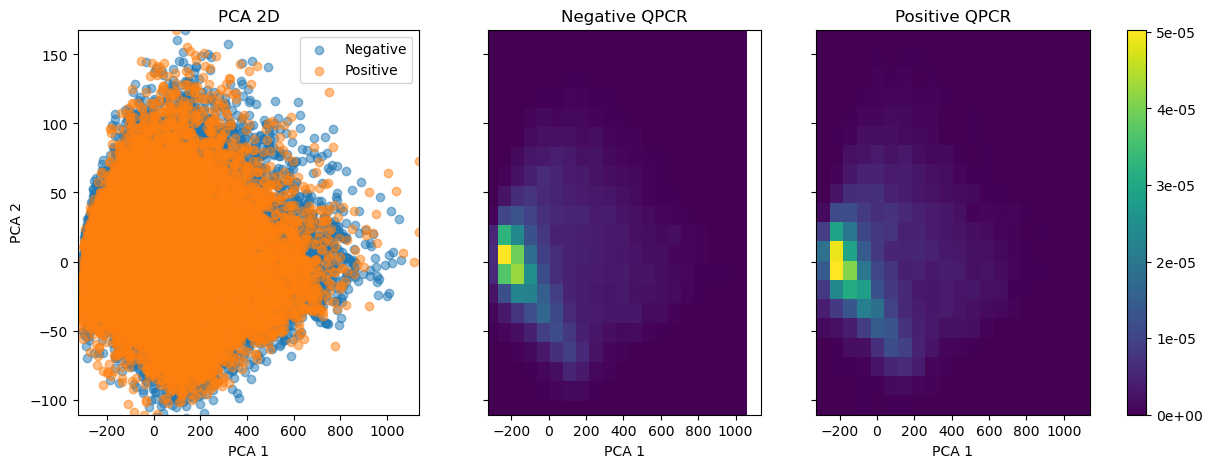

In [6]:
# Make a PCA of all the features except the PCR label and the ratio_red_NDVI2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mask = np.logical_and(df.columns != 'PCR', df.columns != 'ratio_red_NDVI2')
pca.fit(df.loc[:, mask])

# make 2 subplots with histograms 2d with pca transformation with matplotlib
# first subplot is the histogram of PCR value 0
# second subplot is the histogram of PCR value 1
# third subplot is the scatter plot of the PCA
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# plot the scatter plot of the PCA with labels and legend
a1 = ax1.scatter(pca.transform(df.loc[df['PCR'] == 0, mask])[:, 0], pca.transform(df.loc[df['PCR'] == 0, mask])[:, 1], alpha=0.5, label='Negative')
a2 = ax1.scatter(pca.transform(df.loc[df['PCR'] == 1, mask])[:, 0], pca.transform(df.loc[df['PCR'] == 1, mask])[:, 1], alpha=0.5, label='Positive')
# include legend with the different classes
ax1.legend(loc='upper right')
ax1.set_title('PCA 2D')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
# plot the histograms of the different classes
a2 = ax2.hist2d(pca.transform(df.loc[df['PCR'] == 0, mask])[:, 0], pca.transform(df.loc[df['PCR'] == 0, mask])[:, 1], bins=20, alpha=1, label='No PCR', density=True)
ax2.set_title('Negative QPCR')
ax2.set_xlabel('PCA 1')
# cbar = plt.colorbar(a1[3], ax=ax1)
# 

a3 = ax3.hist2d(pca.transform(df.loc[df['PCR'] == 1, mask])[:, 0], pca.transform(df.loc[df['PCR'] == 1, mask])[:, 1], bins=20, alpha=1, label='PCR', density=True)
ax3.set_title('Positive QPCR')
ax3.set_xlabel('PCA 1')
# cbar = plt.colorbar(a2[3], ax=ax2)
# Include shared colorbar between ax1 and ax2. Use scientific notation
fig.colorbar(a3[3], ax=[ax2, ax3], format='%.0e')
plt.show()

In [42]:
from __future__ import division
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

__all__ = ['ks2d2s', 'estat', 'estat2d']


def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    nboot : None or int
        Number of bootstrap resample to estimate the p-value. A large number is expected.
        If None, an approximate analytic estimate will be used.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic, returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. 
    Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation
    is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate,
    but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, MNRAS, 202, 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, MNRAS, 225, 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [43]:
# 2D KS
# Reshape the output of the pca.transform method
x1 = pca.transform(df.loc[df['PCR'] == 0, mask])[:,0]
y1 = pca.transform(df.loc[df['PCR'] == 0, mask])[:,1]
x2 = pca.transform(df.loc[df['PCR'] == 1, mask])[:,0]
y2 = pca.transform(df.loc[df['PCR'] == 1, mask])[:,1]

P, D = ks2d2s(x1, y1, x2, y2, extra=True)
print(f"{P=:.3g}, {D=:.3g}")

P=1.13e-20, D=0.362


In [35]:
from scipy.stats import ks_2samp

# Reshape the output of the pca.transform method
x1 = pca.transform(df.loc[df['PCR'] == 0, mask])[:160, 1]
x2 = pca.transform(df.loc[df['PCR'] == 1, mask])[:, 1]

# Calculate the 2D-KS test statistic and p-value
D, p_value = ks_2samp(x1, x2)

# Print the test statistic and p-value
print("2D-KS test statistic: ", D)
print("p-value: ", p_value)

# Determine if the two distributions are statistically different
alpha = 0.05
if p_value < alpha:
    print("The two distributions are statistically different.")
else:
    print("The two distributions are not statistically different.")

2D-KS test statistic:  0.27561015831134567
p-value:  2.3836003396692107e-09
The two distributions are statistically different.


Accuracy:  0.5519905709795705
Confusion matrix:  [[2182 2427]
 [ 994 2033]]
f1_score 0.5430746627487645
precision_score 0.45582959641255605
recall_score 0.671622068054179
auc_score 0.5725218172772522


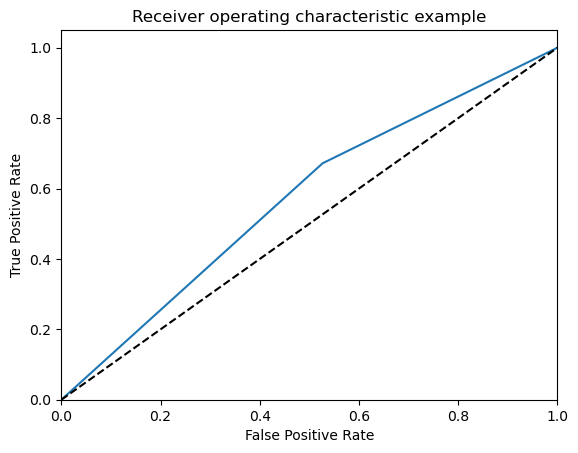

In [7]:
# Train a SVC model with the PCA transformed data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# split the data in train and test set
from sklearn.decomposition import PCA
pca = PCA(n_components=34)
mask = np.logical_and(df.columns != 'PCR', df.columns != 'ratio_red_NDVI2')
pca.fit(df.loc[:, mask])

X_train, X_test, y_train, y_test = train_test_split(pca.transform(df.loc[:, mask]), df['PCR'], test_size=0.2, random_state=0)

# train the model
svc = SVC(kernel='rbf', class_weight='balanced', random_state=0)
svc.fit(X_train, y_train)

# predict the test set
y_pred = svc.predict(X_test)

# print the metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))

# print the f1 score
print('f1_score', f1_score(y_test, y_pred))

# print the precision score
print('precision_score', precision_score(y_test, y_pred))

# print the recall score
print('recall_score', recall_score(y_test, y_pred))

# print the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

# print the auc score
print('auc_score', auc(fpr, tpr))

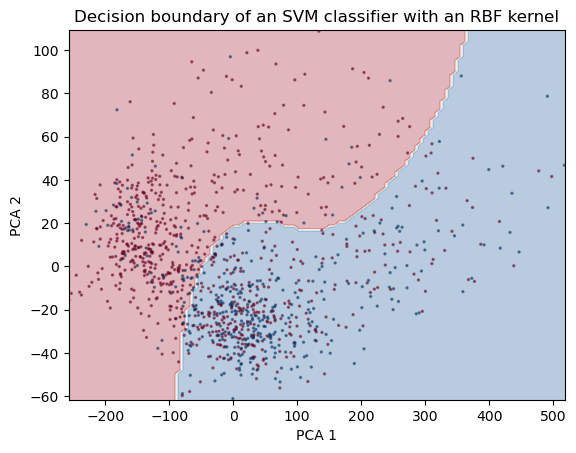

In [45]:
# Generate a grid of points to plot the decision boundary
X = pca.transform(df.loc[:, mask])
y = df['PCR']
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the training points
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu_r, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, alpha=0.5, s=2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Decision boundary of an SVM classifier with an RBF kernel')
plt.show()


In [203]:
from sklearn.model_selection import StratifiedKFold
K = 5
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0) #fix the divisions of the data

In [204]:
trees_set = set(cluster_id_test)
trees_label = {tree: label for tree, label in zip(cluster_id_test, y_test)}

NameError: name 'cluster_id_test' is not defined

In [25]:
# Get lists of trees and labels
trees = list(trees_set)
labels = [trees_label[tree] for tree in trees]

In [26]:
K = 5
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0) #fix the divisions of the data

In [27]:
for train, validate in kfold.split(trees, labels):
    print(train, validate)
    
    break

[ 0  1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26
 27 28 29 31 33 34 36 37 38 39 41 42 44 45 46 47 48 49 50 52 54 55 56 58
 59 62] [ 4  8 18 30 32 35 40 43 51 53 57 60 61]


In [35]:
train_mask = np.isin(cluster_id_test, np.array(trees)[train])

(2594,)

In [6]:
X_test

array([[-1.06095947, -1.52389024, -1.55644798, ...,  2.13646192,
         1.6776804 , -1.65720489],
       [ 0.52034057,  0.09743728, -0.02021897, ...,  0.17571513,
         0.15807483, -0.07834646],
       [-0.27030945, -0.55881433, -0.6272772 , ..., -0.25173985,
        -0.43248375, -0.2752477 ],
       ...,
       [ 0.35485568,  0.15534184,  0.09128153, ..., -0.2648523 ,
        -0.25460927, -0.23597692],
       [ 1.55002432,  1.23622685,  1.56556582, ..., -0.95765505,
        -0.45231523,  0.58883662],
       [ 0.66743825,  0.71508586,  0.3390604 , ..., -0.76252772,
        -1.21279918,  0.23349832]])

In [68]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate random dataset with 1000 rows and 2 features
feature1 = np.random.randint(low=0, high=2, size=10000)
feature2 = np.random.randint(low=0, high=500, size=10000)

# Generate random binary target variable
# all rows with same feature2 value will have the same target value
target = np.where(feature2 > 250, 1, 0)

# Combine features and target into a pandas DataFrame
df = pd.DataFrame({'feature1': feature1, 'feature2': feature2, 'target': target})

# Print the first few rows of the dataset
print(df.head())

   feature1  feature2  target
0         0        50       0
1         1       487       1
2         0        70       0
3         0       479       1
4         0        47       0


In [69]:
# groupby feature_2 and train test split on each group
def groupby_split(df, feature_1, feature_2, test_size):
    # Given df and feature_2, groupby feature_2 and split each group into train and test sets
    # feature_1 is the feature to stratify the split
    # test_size is the size of the test set
    # Return a list of tuples (train, test) where train and test are dataframes
    
    # Create new dataframe with the first row for each unique value of feature_2
    df_new = df.groupby(feature_2).first().reset_index()
    # Stratify the split on feature_1
    train, test = train_test_split(df_new, test_size=test_size, stratify=df_new[feature_1])
    # From the original dataframe, select the rows that have the same values of feature_2 as the train and test dataframes
    train_df = df[df[feature_2].isin(train[feature_2])]
    test_df = df[df[feature_2].isin(test[feature_2])]
    # Return a list of tuples (train, test) where train and test are dataframes
    return train_df, test_df


In [70]:
train_df, test_df = groupby_split(df, 'target', 'feature2', 0.2)

In [74]:
from collections import Counter

feature = 'feature1'

# Print the number of samples in each set
print('Training set size: ', len(train_df))
print('Test set size: ', len(test_df))

# Ensure that the proportion of samples in each set is the same as the original dataset
# Print the proportion samples in each set by dividing the counter by the total number of samples
print('Original dataset proportions: ', get_class_proportions(df, feature))
print('Training set proportions: ', get_class_proportions(train_df, feature) )
print('Test set proportions: ', get_class_proportions(test_df, feature) )

Training set size:  8015
Test set size:  1985
Original dataset proportions:  {0: 0.5013, 1: 0.4987}
Training set proportions:  {0: 0.5010605115408608, 1: 0.4989394884591391}
Test set proportions:  {0: 0.5022670025188917, 1: 0.49773299748110833}


In [72]:
test_df

,feature1,feature2,target
2,0,70,0
6,0,261,1
7,0,83,0
10,0,106,0
12,0,303,1
...,...,...,...
9964,0,96,0
9973,1,209,0
9977,1,327,1
9982,1,181,0


In [44]:
# Define a function that, given a counter, returns the proportion of each class
def get_class_proportions(df, feature):
    counter = Counter(df[feature])
    total = sum(counter.values())
    new_dict = {cl: count / total for cl, count in counter.items()}
    # Sort the dictionary by key
    new_dict = {k: new_dict[k] for k in sorted(new_dict)}
    return new_dict

In [38]:
from sklearn.model_selection import train_test_split

# Specify the features you want to use for stratification
stratify_cols = ['feature1', 'target']

# Split the dataset into a training set and a test set, stratifying based on the specified features
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[stratify_cols], random_state=42)

from collections import Counter

feature = 'feature2'

# Print the number of samples in each set
print('Training set size: ', len(train_df))
print('Test set size: ', len(test_df))

# Ensure that the proportion of samples in each set is the same as the original dataset
# Print the proportion samples in each set by dividing the counter by the total number of samples
print('Original dataset proportions: ', get_class_proportions(df, feature))
print('Training set proportions: ', get_class_proportions(train_df, feature) )
print('Test set proportions: ', get_class_proportions(test_df, feature) )

Training set size:  80
Test set size:  20
Original dataset proportions:  {0: 0.56, 1: 0.44}
Training set proportions:  {0: 0.5375, 1: 0.4625}
Test set proportions:  {0: 0.65, 1: 0.35}


In [2]:
## Create dir to save figures
classification_path = 'Classification figures'
os.makedirs(classification_path, exist_ok=True)

## Load data

In [3]:
df = file_management.load_lzma('Processed Data/QPCR_labelled_df.lzma')
df = df.dropna()
df

,C,B,G,Y,R,RE,N,N2,NDVI_1,NDVI_2,...,NPQI_4,NPQI_5,CLR,CLG,BNDVI,CTR1,cluster_id,Lats,Longs,PCR
66182,89.024270,82.382104,72.421320,72.491339,60.264723,70.815202,76.478698,46.799628,0.118572,-0.125766,...,0.067519,0.077052,0.079976,0.056025,-0.037161,0.676947,285,39.618106,2.583509,1.0
66183,119.044081,106.998271,92.017678,94.714961,74.777452,95.569189,103.451830,65.193512,0.160885,-0.068471,...,0.092949,0.106111,0.082481,0.124260,-0.016852,0.628149,285,39.618106,2.583515,1.0
66184,143.888064,126.691204,106.714946,112.529134,85.846483,116.719747,126.477675,82.306809,0.191364,-0.021050,...,0.110915,0.126643,0.083601,0.185192,-0.000843,0.596620,285,39.618106,2.583520,1.0
66185,156.655110,138.835180,116.939132,124.875591,95.931600,128.783398,139.964241,92.551503,0.186661,-0.017933,...,0.105269,0.120206,0.086819,0.196898,0.004050,0.612375,285,39.618106,2.583526,1.0
66186,160.450719,148.025216,129.719365,135.987402,112.166178,134.893560,146.378584,96.044013,0.132327,-0.077432,...,0.070320,0.080300,0.085141,0.128425,-0.005593,0.699069,285,39.618106,2.583532,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778154,99.375929,95.838942,82.858511,66.847244,71.825711,79.745438,98.517721,67.638269,0.156695,-0.030025,...,0.031586,0.036052,0.235403,0.188987,0.013783,0.722768,2685,39.614768,2.585019,0.0
778155,98.340763,97.480020,85.414557,71.962205,77.483215,78.022059,94.899374,63.680091,0.101032,-0.097781,...,0.007663,0.008746,0.216315,0.111044,-0.013414,0.787905,2685,39.614768,2.585025,0.0
778156,92.474823,92.885002,82.219499,71.785827,76.745280,73.008593,87.827150,57.742825,0.067337,-0.141295,...,-0.003857,-0.004402,0.202970,0.068203,-0.027988,0.829905,2685,39.614768,2.585031,0.0
779120,95.580320,91.900356,79.237445,61.379528,69.857883,75.358655,88.649502,64.727844,0.118554,-0.038117,...,0.034213,0.039049,0.176368,0.118783,-0.018005,0.730881,2685,39.614764,2.585013,0.0


## Save real data for testing

In [4]:
df = df.sample(frac=1, random_state=42)
n_test = int(len(df)*0.05) # 5% of tree pixels for testing
n_train = len(df) - n_test
test_df = df.iloc[:n_test]
train_df = df.iloc[n_test:]

## Data preprocessing

In [5]:
#Data preprocessing: Normalization of spectral bands
# spectral_bands = ['C', 'B', 'G', 'Y', 'R', 'RE', 'N', 'N2']
# X_train = train_df.loc[:, spectral_bands] # only spectral bands
X_train = train_df.iloc[:, :-4] # spectral bands + indices
#X_train = train_df.iloc[:, 8:-4] # indices
X_test = test_df.iloc[:, :-4] 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = train_df['PCR'].values
Y_test = test_df['PCR'].values

In [6]:
n_features = X_train.shape[1]

print(Counter(Y_train))

Counter({0.0: 28731, 1.0: 9585})


## SVC with penalization for the minority class

## Balance the dataset using oversampling techniques

In [8]:
#random.seed(42)
#
#c = list(zip(X_train, Y_train))
#random.shuffle(c)
#X_train, Y_train = zip(*c)
#X_train = np.array(X_train)
#Y_train = np.array(Y_train)

file_management.save_lzma(X_train, 'X_train.lzma', '')
file_management.save_lzma(Y_train, 'Y_train.lzma', '')
file_management.save_lzma(X_test, 'X_test.lzma', '')
file_management.save_lzma(Y_test, 'Y_test.lzma', '')

## UMAP

In [11]:
from umap import UMAP

/home/jgalvan/.conda/envs/xylella_tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
X1 = X[5000:, :]
Y1 = Y[5000:]

X1.shape

(15833, 27)

In [18]:
# Visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt # for showing handwritten digits

def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    fig.show()

## Explore the differences between the two classes

## Train a simple neural network usign 7-fold validation

In [7]:
## Since there exist an unbalance in the dataset we perform some 
# over_sampling techniques (SMOTE)
from imblearn.over_sampling import ADASYN, RandomOverSampler

#ros = RandomOverSampler(random_state=42, ratio=1.0)
#X_train, Y_train = ros.fit_resample(X_train, Y_train)

adasyn = ADASYN(random_state=42)
# X_train, Y_train = adasyn.fit_resample(X_train, Y_train)

In [8]:
# =============================================================================
# ANN: 1 pixel = 1 tree
# =============================================================================

# Define the K-fold Cross Validator
num_folds = 7
#n_features = 27
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0) #fix the divition

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

#Set the training parameters
num_epochs = 15000
verbosity = 1 #0:silent, 1:to show a progress bar during the training, 2:show results after each epoch

#initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
initializer = tf.keras.initializers.GlorotNormal(seed=42)

# Define the model architecture
def model():
    classifier = Sequential()
    # First layer
    classifier.add(Dense(units = 128, input_dim = n_features, kernel_initializer = initializer,  activation = "relu"))
    # Second layer
    classifier.add(Dense(units = 64, kernel_initializer = initializer,  activation = "relu"))
    #classifier.add(Dropout(rate = 0.2))
    # Third layer
    classifier.add(Dense(units = 32, kernel_initializer = initializer,  activation = "relu"))
    #classifier.add(Dropout(rate = 0.2))
    
    classifier.add(Dense(units = 8, kernel_initializer = initializer,  activation = "relu"))

    # Output layer
    classifier.add(Dense(units = 1, kernel_initializer = initializer,  activation = "sigmoid"))

    # Compilar la RNA
    classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    return classifier

# def model():
#     classifier = Sequential()
#     # First layer
#     classifier.add(Dense(units = 1, input_dim = n_bands, kernel_initializer = "uniform",  activation = "sigmoid"))
    
#     # Compilar la RNA
#     classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
#     return classifier

In [9]:
# K-fold Cross Validation model evaluation
ground_acc = 0

fold_no = 1
for train, validate in kfold.split(X_train, Y_train):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    classifier = model()
    
    # Oversample the training set
    X_train_balanced, Y_train_balanced = adasyn.fit_resample(X_train[train], Y_train[train])
    X_val, Y_val = X_train[validate], Y_train[validate]
    n_training_examples = X_train_balanced.shape[0]

    
    # Fit data to model    
    history = classifier.fit(X_train_balanced, Y_train_balanced, 
                             validation_data = (X_val, Y_val), 
                             batch_size = n_training_examples, epochs = num_epochs, verbose=verbosity)

    # Generate generalization metrics
    scores = classifier.evaluate(X_val, Y_val, verbose=0)
    print(f'Score for fold {fold_no}: {classifier.metrics_names[0]} of {scores[0]}; {classifier.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    if scores[1]>ground_acc:
        ground_acc = scores[1]
        classifier.save('ann_classifier_best_new.h5')
        #file_management.save_lzma(train, 'train_set.lzma', '')
        file_management.save_lzma(validate, 'validate_set.lzma', '')
        train_set = train
        validate_set = validate
        
        train_acc2 = history.history['accuracy']
        val_acc2 = history.history['val_accuracy']
        train_loss2 = history.history['loss']
        val_loss2 = history.history['val_loss']
            
    # Increase fold number
    fold_no = fold_no + 1


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...


2023-03-06 19:07:59.538688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /common/amd/aocl/2.1/amd-fftw/lib:/common/amd/aocl/2.1/libs:/opt/AMD/aocc-compiler-2.1.0/lib:/opt/AMD/aocc-compiler-2.1.0/lib32:/usr/lib/x86_64-linux-gnu:/usr/lib64:/usr/lib32:/usr/lib:/common/opt_intel/oneapi/vpl/2021.2.2/lib:/common/opt_intel/oneapi/tbb/2021.2.0/env/../lib/intel64/gcc4.8:/common/opt_intel/oneapi/mkl/latest/lib/intel64:/common/opt_intel/oneapi/itac/2021.2.0/slib:/common/opt_intel/oneapi/ipp/2021.2.0/lib/intel64:/common/opt_intel/oneapi/ippcp/2021.2.0/lib/intel64:/common/opt_intel/oneapi/ipp/2021.2.0/lib/intel64:/common/opt_intel/oneapi/dnnl/2021.2.0/cpu_dpcpp_gpu_dpcpp/lib:/common/opt_intel/oneapi/debugger/10.1.1/dep/lib:/common/opt_intel/oneapi/debugger/10.1.1/libipt/intel64/lib:/common/opt_intel/oneapi/debugger/10.1.1/gdb/intel64/li

Epoch 1/15000
1/1 [==============================] - 1s 1s/step - loss: 0.6933 - accuracy: 0.4789 - val_loss: 0.6910 - val_accuracy: 0.6293
Epoch 2/15000
1/1 [==============================] - 0s 94ms/step - loss: 0.6928 - accuracy: 0.5157 - val_loss: 0.6900 - val_accuracy: 0.6213
Epoch 3/15000
1/1 [==============================] - 0s 96ms/step - loss: 0.6924 - accuracy: 0.5319 - val_loss: 0.6867 - val_accuracy: 0.6944
Epoch 4/15000
1/1 [==============================] - 0s 97ms/step - loss: 0.6922 - accuracy: 0.5211 - val_loss: 0.6831 - val_accuracy: 0.7280
Epoch 5/15000
1/1 [==============================] - 0s 94ms/step - loss: 0.6920 - accuracy: 0.5091 - val_loss: 0.6803 - val_accuracy: 0.7340
Epoch 6/15000
1/1 [==============================] - 0s 93ms/step - loss: 0.6918 - accuracy: 0.5061 - val_loss: 0.6791 - val_accuracy: 0.7256
Epoch 7/15000
1/1 [==============================] - 0s 93ms/step - loss: 0.6915 - accuracy: 0.5097 - val_loss: 0.6790 - val_accuracy: 0.7119
Epoch 8/

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# DRAW THE LEARNING CURVES FOR THE BEST K-FOLD
# =============================================================================
#classifier = model()
# history = classifier.fit(X[train_set], Y[train_set], validation_data = (X[test_set], Y[test_set]), batch_size = number_examples, epochs = num_epochs, verbose=verbosity)
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = np.arange(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1
                               
                               ,2, figsize=(7.5, 5), sharex=True)
#Draw accuracy curve
ax1.plot(epochs, train_acc2, 'r-', label='Training set')
ax1.plot(epochs, val_acc2, 'b-', label='Cross-validation set')
ax1.axhline(1- sum(Y_train[validate_set])/len(Y_train[validate_set]), label='Negatives ratio', color='k')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.legend(loc='best', fontsize=12)
#Draw cost curve
ax2.plot(epochs, train_loss2, 'r-', label='Training set')
ax2.plot(epochs, val_loss2, 'b-', label='Cross-validation set')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(classification_path, 'ann_learning_curves3.png'), dpi=300, transparent=True)

In [19]:
# =============================================================================
# CONFUSSION MATRIX FOR THE BEST CLASSIFIER OVER VALIDATION SET
# =============================================================================
# Load the best classifier
best_model_path = 'Classification figures/num_epochs_25000_oversampling_True_dropout_True '
best_model = keras.models.load_model(os.path.join(best_model_path, 'ann_classifier_best_new.h5'))

#train_set = file_management.load_lzma('train_set.lzma')
validate_set = file_management.load_lzma(os.path.join(best_model_path,'validate_set.lzma'))
# We evaluate the best classifier on its fold
y_pred = best_model.predict(X_train[validate_set])

Y_pred = np.round(y_pred)
cm=confusion_matrix(Y_train[validate_set],Y_pred)
print(cm)

60/60 [==============================] - 1s 2ms/step
[[1081  324]
 [ 174  311]]


In [21]:
# =============================================================================
# OBTAIN ACCURACY, RECALL, PRECISION, F1SCORE FOR BEST MODEL
# =============================================================================
# Evalute its accuracy over the last kfold
accuracy = accuracy_score(Y_train[validate_set], Y_pred)
recall = recall_score(Y_train[validate_set], Y_pred)
precision = precision_score(Y_train[validate_set], Y_pred)
f1score = f1_score(Y_train[validate_set], Y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))
print("Recall: %.2f%%" % (recall*100))
print("Precision: %.2f%%" % (precision*100))
print("F1-score: %.2f%%" % (f1score*100))
print("Proportion of positives: %.2f%%" %(100*sum(Y_train[validate_set]/len(Y_train[validate_set]))))

Accuracy: 73.65%
Recall: 64.12%
Precision: 48.98%
F1-score: 55.54%
Proportion of positives: 25.66%


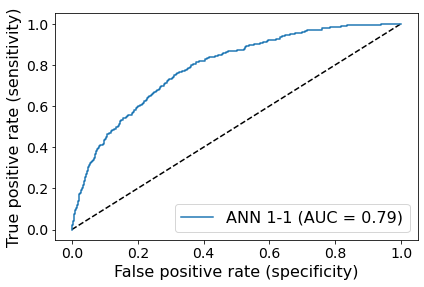

In [22]:
# =============================================================================
# ROC and AUC
# =============================================================================
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_train[validate_set], y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN 1-1 (AUC = {:.2f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate (specificity)', fontsize=16)
plt.ylabel('True positive rate (sensitivity)', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(classification_path, 'roc_curve_validation_ANN11.png'), dpi=300, transparent=True)

## Test set evaluation

In [24]:
# =============================================================================
# CONFUSSION MATRIX FOR THE BEST CLASSIFIER OVER TEST SET
# =============================================================================
# Load the best classifier
#best_model = keras.models.load_model('ann_classifier_best_new.h5')

X_test = file_management.load_lzma('X_test.lzma')
Y_test = file_management.load_lzma('Y_test.lzma')

# We evaluate the best classifier on its fold
y_test_pred = best_model.predict(X_test)

Y_test_pred = np.round(y_test_pred)
cm=confusion_matrix(Y_test,Y_test_pred)
print(cm)

22/22 [==============================] - 0s 2ms/step
[[416 117]
 [ 62 101]]


In [25]:
# =============================================================================
# OBTAIN ACCURACY, RECALL, PRECISION, F1SCORE FOR BEST MODEL
# =============================================================================
# Evalute its metrics
accuracy = accuracy_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)
f1score = f1_score(Y_test, Y_test_pred)
print("Accuracy: %.2f%%" % (accuracy*100))
print("Recall: %.2f%%" % (recall*100))
print("Precision: %.2f%%" % (precision*100))
print("F1-score: %.2f%%" % (f1score*100))
print("Proportion of positives: %.2f%%" %(100*sum(Y_test)/len(Y_test)))

Accuracy: 74.28%
Recall: 61.96%
Precision: 46.33%
F1-score: 53.02%
Proportion of positives: 23.42%


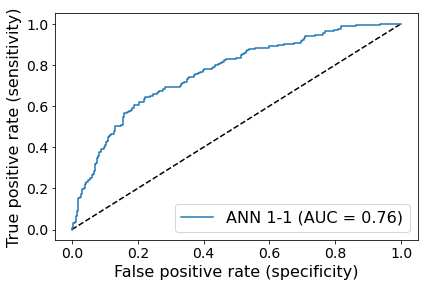

In [26]:
# =============================================================================
# ROC and AUC
# =============================================================================
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ANN 1-1 (AUC = {:.2f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate (specificity)', fontsize=16)
plt.ylabel('True positive rate (sensitivity)', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(classification_path, 'roc_curve_test_ANN11.png'), dpi=300, transparent=True)

## SVM